将原图+mask转为labelme的json格式

- 1.收集生成json的mask信息

- 2.按照json模板进行数据填写

In [1]:
import glob
import cv2
import json
import os.path as ops
import numpy as np
from base64 import b64encode
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [2]:
#查看图片
def show_images(images,closize=2,set_locator=False,titles=[]):
    """[展示一组照片]

    Args:
        images ([list(2D or 3D ndarray)]): [图片列表]
        closize (int, optional): [每行的图片个数]. Defaults to 2.
        set_locator (bool, optional): [是否设置刻度线]. Defaults to False.
        titles (list, optional): [图片标题]. Defaults to [].
    """    
    rows=int(len(images)/closize)+1
    fig=plt.figure(figsize=(34,14))
    
    xmajorLocator = MultipleLocator(100)  # 将x主刻度标签设置为50的倍数
    xminorLocator = MultipleLocator(50) #将x轴次刻度标签设置为5的倍数
    
    ymajorLocator = MultipleLocator(100)
    yminorLocator = MultipleLocator(50) #将x轴次刻度标签设置为5的倍数
    
    for find,image in enumerate(images):
        if not np.any(image>1):
            image=image*255
        ax=fig.add_subplot(rows,closize,find+1)
        ax.imshow(image)
        
        if len(titles)==0:
            plt.title('{}-({})'.format(find,image.shape)) #图片大小作为标题
        else:
            plt.title('{}-({})'.format(titles[find],image.shape)) #自定义标题
        
        if set_locator:
            #主刻度
            ax.xaxis.set_major_locator(xmajorLocator)
            ax.yaxis.set_major_locator(ymajorLocator)
            
            #次刻度
            ax.xaxis.set_minor_locator(xminorLocator)
            ax.yaxis.set_minor_locator(yminorLocator)
            
            ax.xaxis.grid(True, which='major',linestyle='-.') #x坐标轴的网格使用主刻度
            ax.yaxis.grid(True, which='major',linestyle='-.') #x坐标轴的网格使用主刻度
    plt.show()

In [3]:
images_path='./'
clanames=['line','point','salient','sully','blue_point','nick','pit','scallops','shadow']

files_path=glob.glob(ops.join(images_path,'images',clanames[1],'*.jpg'))

0


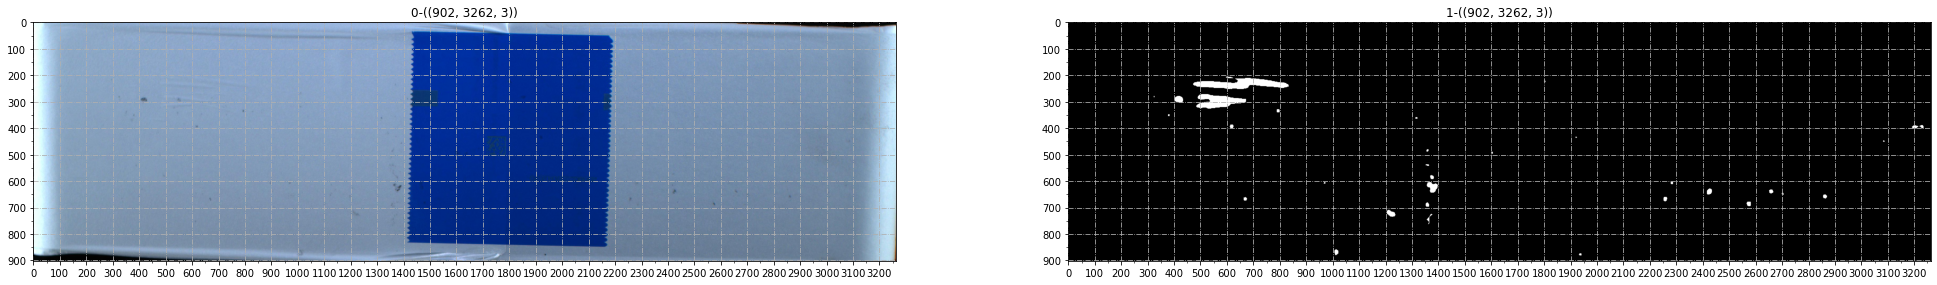

In [4]:
#读取图片及mask
getind=0
print(getind)
file_path=files_path[getind]
file_name=ops.basename(file_path)
image=cv2.imread(file_path)
mask=cv2.imread(file_path.replace('images','masks').replace('.jpg','.png'))
show_images([image[...,::-1],mask],set_locator=True)
getind+=1

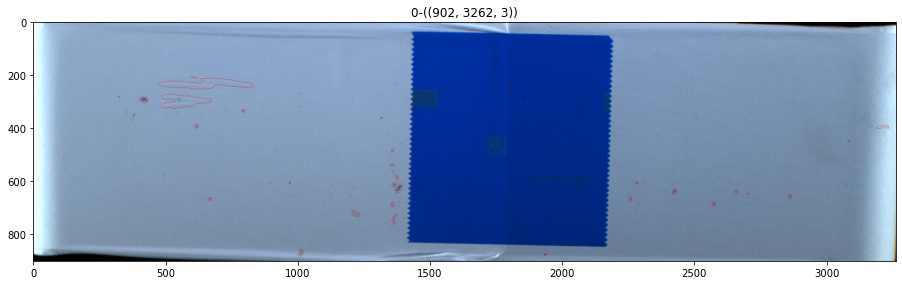

In [5]:
#查找mask信息
img_add_mask=image.copy()
mask=mask.astype(np.uint8)
contours,_  = cv2.findContours(mask[...,0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #原始mask
for mask_ind,contour in enumerate(contours):
    cv2.drawContours(img_add_mask, [contour], 0,(0,0,255), 1) #绘制边界
show_images([img_add_mask[...,::-1]])

In [13]:
#移除距离小于2的点集
def remove_points(contour,mindis=2):
    new_contour=contour.reshape((contour.shape[0],contour.shape[-1]))
    
    if (len(new_contour))<6:#点集数量太少，直接返回
        return new_contour
    
    ind=0
    while ind<len(new_contour):
        cur_dis=np.sqrt(np.sum((new_contour[ind+1:]-new_contour[ind])**2,axis=1))
        #更新contour
        delnum=0
        for ind_p in range(len(cur_dis)):
            if cur_dis[ind_p]<=mindis:
                new_contour=np.delete(new_contour,ind+ind_p+1-delnum,0)
                delnum+=1
        ind+=1
    return new_contour

In [15]:
#加载json模板
with open('labelme4.5.6_template.json','r',encoding='utf-8') as fr:
    labelme_template=json.load(fr)
print(labelme_template)

# 给模板赋值
# labelme_template['version']='4.5.6'
# labelme_template['flags']={}

# 点集太多，考虑减少
labelme_template['shapes']=[]
for mask_ind,contour in enumerate(contours):
    #移除点集中靠近的点
    new_contour=remove_points(contour,mindis=5)
    print(len(contour),len(new_contour))
    shape={}
    shape['label']='all'
    shape['points']=[]

    for point in new_contour:
        assert len(point.shape)==1
        shape['points'].append(point.tolist())
    labelme_template['shapes'].append(shape)
    shape['group_id']=None
    shape['shape_type']='polygon'
    shape['flags']={}
    
labelme_template['imagePath']='..\\images\\%s'%file_name
labelme_template['imageData']=b64encode(open(file_path, "rb").read()).decode('utf-8')
labelme_template['imageHeight']=mask.shape[0]
labelme_template['imageWidth']=mask.shape[1]

# print(labelme_template)

{'version': '4.5.6', 'flags': {}, 'shapes': [{'label': '', 'points': [], 'group_id': None, 'shape_type': 'polygon', 'flags': {}}], 'imagePath': '', 'imageData': '', 'imageHeight': -1, 'imageWidth': -1}
10 4
19 7
27 7
35 14
12 5
13 5
16 5
14 5
1 1
17 6
9 3
17 6
24 7
48 16
6 2
9 3
17 6
8 3
7 3
9 3
6 2
7 2
18 6
14 5
14 6
6 3
5 5
8 4
22 11
4 4
96 43
11 2
110 53
16 4


In [16]:
#将json_dict保存为json
def WriteFile(filename,s_body,mode='w+',encoding = 'utf-8'):
    try:
        fp = open(filename, mode,encoding = encoding);
        fp.write(s_body)
        fp.close()
        return True
    except:
        return False
    
WriteFile('jsons/%s.json'%file_name.replace('.jpg',''),
          json.dumps(labelme_template, ensure_ascii=False, indent=2, separators=(',',': ')) )#ensure_ascii：使用中文保存，缩进为4个空格

True